In [1]:
!pip install timesynth
import ts_syntheticData
import ts_dataloader
from ts_dataloader import get_train_valid_test_signals
from ts_simple_LSTM_net import Standard_LSTM, loss_function_normal
from ts_training import train_network
import torch
from torch import optim
from torch.utils.data import DataLoader
from ts_VI_LSTM import Variational_LSTM, loss_normal2d

In [2]:
USEDATASET = 0  # simple synthetic dataset
# USEDATASET = 1 # correlated synthetic dataset

# %% set device
use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')

# number of samples in the time series
T = 1000
# width of the window of each time series
W = 101
# the size of train and validation, test is the remainder of the data
t_v_t_split = [0.5,0.3]

#load the data in, this is supposed to happen only once
features, train_dataset, valid_dataset, test_dataset = get_train_valid_test_signals(T,W,USEDATASET,t_v_t_split, device)
train_T = len(train_dataset)
valid_T = len(valid_dataset)
test_T = len(test_dataset)

Dataset created.


In [9]:
# Here we can change to batch size
# batch size (number of serieses of length W)
B = 100
# check for consistency, we don't want to pad the sequence if possible
if (train_T - W + 1) % B != 0 :
    raise ValueError("The batch size chosen will result in different sized batches during training")

# create the Synthetic Dataset
train_loader = DataLoader(train_dataset, batch_size=B, shuffle=True)
valid_loader = DataLoader(valid_dataset, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

Starting training
Epoch: 0
Epoch: 10
Epoch: 20
Epoch: 30
Epoch: 40


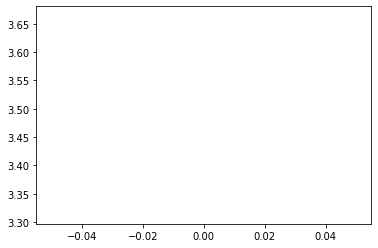

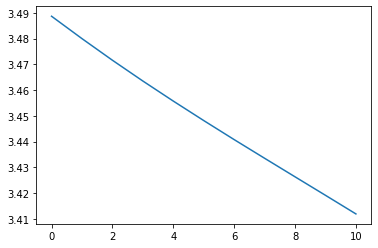

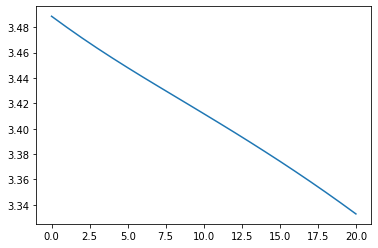

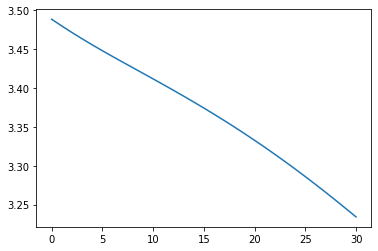

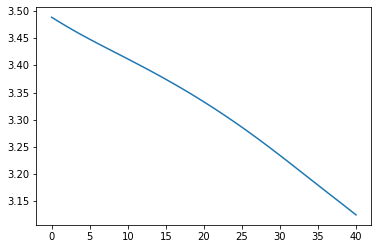

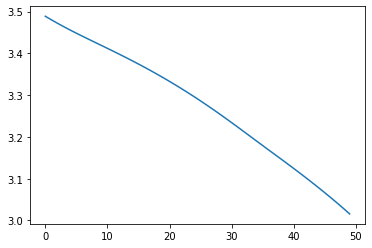

In [10]:
epochs = 50
params_distribution = 2
hidden_layer_size = 5

#define the network
net = Standard_LSTM(features, params_distribution, hidden_layer_size)
#push it to the correct device
net.to(device)
#define the loss function
loss_function = loss_function_normal
#define the optimizer with the learning rate
optimizer = optim.Adam(net.parameters(), lr=0.001)

#here define eventual scheduler

#run the training
net_state_dict = train_network(device, train_loader, valid_loader, epochs, net, loss_function, optimizer)

Starting training
Epoch: 0


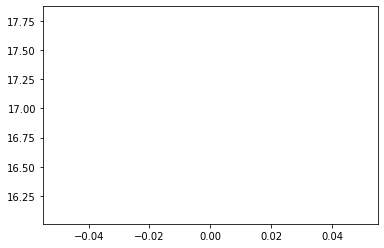

KeyboardInterrupt: 

In [8]:
epochs = 50
params_distribution = 2
hidden_dim_gen = 5
hidden_dim_rec = 5
latent_dim = 2

#define the network
net = Variational_LSTM(features, params_distribution, hidden_dim_rec, hidden_dim_gen, latent_dim)
#push it to the correct device
net.to(device)
#define the loss function
loss_function = loss_normal2d
#define the optimizer with the learning rate
optimizer = optim.Adam(net.parameters(), lr=0.001)

#here define eventual scheduler

#run the training
net_state_dict = train_network(device, train_loader, valid_loader, epochs, net, loss_function, optimizer)

In [11]:
net.load_state_dict(net_state_dict)



<All keys matched successfully>

In [14]:
import numpy as np
net.eval()
valid_loss = []
for batch_idx, x in enumerate(valid_loader):
    input = x

    output_model = net(input, device)

    loss_params = loss_function(output_model, device)
    valid_loss.append(loss_params["loss"].item())

print(np.mean(valid_loss))
    

2.8624061191082
